# Carbohydrate glucoside hydrolases

In [2]:
import pathlib, itertools
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt, numpy as np
import scipy.spatial.distance as dist, itertools
import skbio.diversity as div, scipy.stats as stats, skbio.stats.ordination as ordination
from matplotlib.lines import Line2D

sns.set_style('white')
%matplotlib inline

In [3]:
#get patient colors
dd_pat_col = {'0044': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
              '0073': (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
              '001': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
              '004': (1.0, 0.4980392156862745, 0.054901960784313725),
              '005': (1.0, 0.7333333333333333, 0.47058823529411764),
              '006': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
              '007': (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
              '008': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
              '009': (1.0, 0.596078431372549, 0.5882352941176471),
              '010': (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
              '011': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
              '012': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
              '013': (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
              '014': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274)}
dd_pat_col_name = {'patient_' + str(k): v for k, v in dd_pat_col.items()}

#get patient colors on treatment
dd_pat_treat = {'0044': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
              '0073': (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
              '001': sns.color_palette()[0], '004': sns.color_palette()[1],
              '005': sns.color_palette()[1], '006': sns.color_palette()[1],
              '007': sns.color_palette()[0], '008': sns.color_palette()[0],
              '009': sns.color_palette()[1], '010': sns.color_palette()[0],
              '011': sns.color_palette()[0], '012': sns.color_palette()[1],
              '013': sns.color_palette()[1], '014': sns.color_palette()[0]}
dd_pat_treat_name = {'patient_' + str(k): v for k, v in dd_pat_treat.items()}

#get patient dashes on responder
dd_pat_dash = {'0044': (), '0073': (),
               '001': (), '004': (), '005': (),
               '006': (), '007': (3, 2), '008': (3, 2),
               '009': (), '010': (), '011': (),
               '012': (), '013': (), '014': (3, 2)}
dd_pat_dash_name = {'patient_' + str(k): v for k, v in dd_pat_dash.items()}

In [4]:
#read in metadata
md = pd.read_csv('/Users/ndchu/Documents/uc_fmt/metadata/metadata_stooldna_OC162018.tsv',
                 sep='\t', dtype={'patient': 'object',
                                  'fmt': 'object',
                                  'fmt_induction': 'object'})

md.loc[:, 'patient_plt'] = 'patient_' + md['patient']

#read in patient metadata
md_pat = pd.read_csv('/Users/ndchu/Documents/uc_fmt/metadata/metadata_patients_2019-04-10.tsv',
                     sep='\t', dtype={'patient': 'object',
                                      'fmt': 'object',
                                      'fmt_induction': 'object'})

#read in sb results file
cazygh = pd.read_csv('/Users/ndchu/Documents/uc_fmt/metagenomics/function/cazy_gh/all_sbresults_nz.txt.gz',
                     sep='\t', compression='gzip')

In [5]:
#filter for where Count > 0
cazygh_f = cazygh.loc[cazygh['Count'] > 0]

#get samples that have mgx sequencing
samples = md.loc[(md['reads_mgx'] > 0) & (md['patient'].notnull())]['sample_id'].unique()

#add metadata
cazygh_f_md = cazygh_f.merge(md, left_on='sample', right_on='sample_id')

## Gene cluster counts

In [6]:
# get count of cazygh gene cluster hits
cazygh_ct = cazygh_f[['sample', 
                    'Count']].groupby('sample').size().rename('sb_clust_count').reset_index()

#add any missing samples
sam_missing = [x for x in samples if x not in cazygh_ct['sample'].values]
missing_df = pd.DataFrame({'sample': sam_missing,
                           'Count': [0] * len(sam_missing), 
                           'Hits': [0] * len(sam_missing)})
cazygh_ct = cazygh_ct.append(missing_df)

#add metadata
cazygh_ct = cazygh_ct.merge(md, left_on='sample', right_on='sample_id')

/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


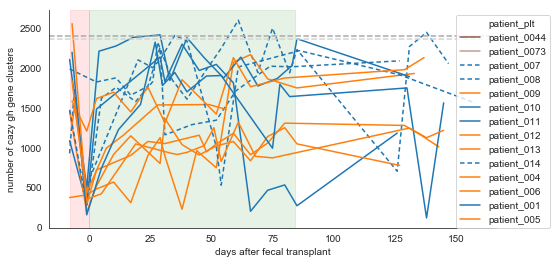

In [15]:
# for each patient, plot the total butyrate cluster counts over time

#get mean abundance for each donor
cazygh_mean_0044 = cazygh_ct.loc[cazygh_ct['patient'] == '0044']['sb_clust_count'].mean()
cazygh_mean_0073 = cazygh_ct.loc[cazygh_ct['patient'] == '0073']['sb_clust_count'].mean()

fig = plt.figure(figsize = (8,4))

ax = sns.lineplot(x='days_past_fmt', y='sb_clust_count',
                  data=cazygh_ct,
                  hue='patient_plt', 
                  palette=dd_pat_treat_name,
                  style='patient_plt',
                  dashes=dd_pat_dash_name,
                  ci=None)

#label axes
ax.set_ylabel('number of cazy gh gene clusters')
ax.set_xlabel('days after fecal transplant')

#label regions of the graph
ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax.axvspan(0, 84, alpha=0.1, color='green') #capsules

#add a line for the mean abundance in the donor samples
ax.axhline(cazygh_mean_0044, color='lightgrey', linestyle='dashed')
ax.axhline(cazygh_mean_0073, color='darkgrey', linestyle='dashed')

ax.legend(loc='upper left', bbox_to_anchor=(.9, 1))

sns.despine()

#plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/cazygh_genecluster_counts_20190206.png',
#            dpi=300)

## Collapsing over time windows

In [8]:
#let's get simply smash everything into 5-day windows
ct_window_mean_dfs = []
for patient, sub_df in cazygh_ct.groupby('patient'):
    #we'll want to join all baseline samples
    #join all abx range samples
    #have the rest in chunks
    if patient in ['0044', '0073']:
        continue
    
    #get baseline and abx
    bl = sub_df.loc[sub_df['days_past_fmt'] < -5]
    bl.loc[:, 'chunk_time'] = -5
    bl_mean = bl.groupby(['patient', 'chunk_time']).mean()['sb_clust_count']
    bl_mean = bl_mean.reset_index()
    abx = sub_df.loc[sub_df['days_past_fmt'].between(-5, 1)]
    if abx.empty:
        abx_mean = pd.DataFrame({'patient': [],
                                 'chunk_time': [],
                                 'sb_clust_count': []})
    else:
        abx.loc[:, 'chunk_time'] = 0
        abx_mean = abx.groupby(['patient', 'chunk_time']).mean()['sb_clust_count']
        abx_mean = abx_mean.reset_index()
    
    pfmt = sub_df.loc[sub_df['days_past_fmt'] > 1]
    pfmt_chunks = []
    for day_range in zip(range(0, int(sub_df['days_past_fmt'].max()), 5),
                         range(5, int(sub_df['days_past_fmt'].max()), 5)):
        chunk = sub_df.loc[sub_df['days_past_fmt'].between(day_range[0], day_range[1])]
        #add time range information
        if chunk.empty:
            chunk = chunk.append({'chunk_time': day_range[1]}, ignore_index=True)
        else:
            chunk.loc[:, 'chunk_time'] = day_range[1]
        pfmt_chunks.append(chunk)
    #now get the mean of values in each chunk
    pfmt_chunks = [chunk.groupby(['patient', 'chunk_time']).mean()['sb_clust_count'] \
                   for chunk in pfmt_chunks]
    pfmt_chunks = [chunk.reset_index() for chunk in pfmt_chunks]
    pfmt_mean = pd.concat(pfmt_chunks)
    
    ct_window_mean_dfs.append(pd.concat([bl_mean, abx_mean, pfmt_mean]))

ct_window_mean_df = pd.concat(ct_window_mean_dfs)

/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [9]:
#add metadata
tmp_md = md[['patient', 'patient_donor', 'treatment', 
             'fmt_induction', 'clinical_response', 
             'patient_plt']].drop_duplicates()
ct_window_mean_df = ct_window_mean_df.merge(tmp_md)

In [9]:
#write this to a file
ct_window_mean_df.to_csv('/Users/ndchu/Documents/uc_fmt/metagenomics/function/cazy_gh/window_means_cts_2019-04-15.tsv',
                         sep='\t', index=False)

In [ ]:
#read this file
ct_window_mean_df = pd.read_csv('/Users/ndchu/Documents/uc_fmt/metagenomics/function/cazy_gh/window_means_cts_2019-04-15.tsv',
                                 sep='\t')

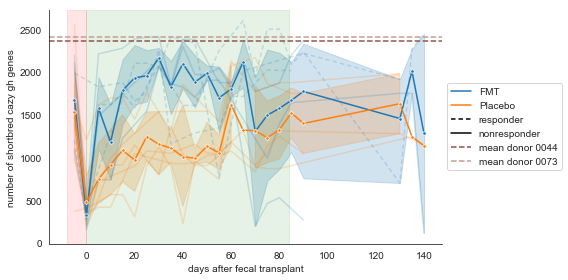

In [38]:
# for each patient, plot the total butyrate cluster counts over time

fig = plt.figure(figsize = (8,4))

#get mean abundance for each donor
cazygh_mean_0044 = cazygh_ct.loc[cazygh_ct['patient'] == '0044']['sb_clust_count'].mean()
cazygh_mean_0073 = cazygh_ct.loc[cazygh_ct['patient'] == '0073']['sb_clust_count'].mean()

ax = sns.lineplot(x='chunk_time', y='sb_clust_count',
                  data=ct_window_mean_df,
                  hue='patient_plt', 
                  palette=dd_pat_treat_name,
                  style='patient_plt',
                  dashes=dd_pat_dash_name,
                  alpha = 0.2)

ax = sns.lineplot(x='chunk_time', y='sb_clust_count',
                  data=ct_window_mean_df,
                  hue='treatment', marker='.', markersize=7)

#label axes
ax.set_ylabel('number of shortbred cazy gh genes')
ax.set_xlabel('days after fecal transplant')

#label regions of the graph
ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax.axvspan(0, 84, alpha=0.1, color='green') #capsules

#add a line for the mean abundance in the donor samples
ax.axhline(cazygh_mean_0044, color=dd_pat_col['0044'], linestyle='dashed')
ax.axhline(cazygh_mean_0073, color=dd_pat_col['0073'], linestyle='dashed')

#make legends for both plots
legend_elements = [Line2D([0], [0], color=sns.color_palette()[0], label='FMT'),
                   Line2D([0], [0], color=sns.color_palette()[1], label='Placebo'),
                   Line2D([0], [0], color='black', dashes=(3, 2), label='responder'),
                   Line2D([0], [0], color='black', dashes=(), label='nonresponder'),
                   Line2D([0], [0], color=dd_pat_col['0044'], linestyle='dashed', 
                          label='mean donor 0044'),
                   Line2D([0], [0], color=dd_pat_col['0073'], linestyle='dashed', 
                          label='mean donor 0073')]
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1,0.5))

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/cazy_gh_genecluster_counts_mean_20190206.png',
            dpi=300)

In [11]:
#Do T-test for each data point
ttest_res = []
for time, sub_df in ct_window_mean_df.groupby('chunk_time'):
    fmt = sub_df.loc[sub_df['treatment'] == 'fmt']
    placebo = sub_df.loc[sub_df['treatment'] == 'placebo']
    t_res = stats.ttest_ind(fmt['sb_clust_count'], placebo['sb_clust_count'])
    ttest_res.append([time, *t_res])
ttest_res = pd.DataFrame(ttest_res, columns=['chunk_time', 't_stat', 'p'])

/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


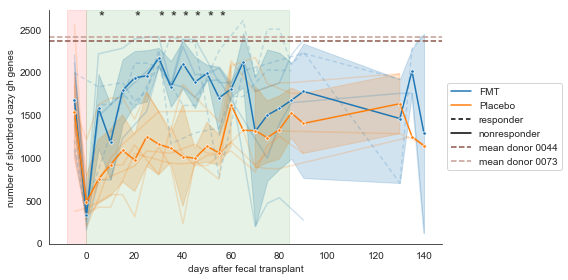

In [40]:
# for each patient, plot the total butyrate cluster counts over time

fig = plt.figure(figsize = (8,4))

#get mean abundance for each donor
cazygh_mean_0044 = cazygh_ct.loc[cazygh_ct['patient'] == '0044']['sb_clust_count'].mean()
cazygh_mean_0073 = cazygh_ct.loc[cazygh_ct['patient'] == '0073']['sb_clust_count'].mean()

ax = sns.lineplot(x='chunk_time', y='sb_clust_count',
                  data=ct_window_mean_df,
                  hue='patient_plt', 
                  palette=dd_pat_treat_name,
                  style='patient_plt',
                  dashes=dd_pat_dash_name,
                  alpha = 0.2)

ax = sns.lineplot(x='chunk_time', y='sb_clust_count',
                  data=ct_window_mean_df,
                  hue='treatment', marker='.', markersize=7)

#label axes
ax.set_ylabel('number of shortbred cazy gh genes')
ax.set_xlabel('days after fecal transplant')

#label regions of the graph
ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax.axvspan(0, 84, alpha=0.1, color='green') #capsules

#add a line for the mean abundance in the donor samples
ax.axhline(cazygh_mean_0044, color=dd_pat_col['0044'], linestyle='dashed')
ax.axhline(cazygh_mean_0073, color=dd_pat_col['0073'], linestyle='dashed')

#make legends for both plots
legend_elements = [Line2D([0], [0], color=sns.color_palette()[0], label='FMT'),
                   Line2D([0], [0], color=sns.color_palette()[1], label='Placebo'),
                   Line2D([0], [0], color='black', dashes=(3, 2), label='responder'),
                   Line2D([0], [0], color='black', dashes=(), label='nonresponder'),
                   Line2D([0], [0], color=dd_pat_col['0044'], linestyle='dashed', 
                          label='mean donor 0044'),
                   Line2D([0], [0], color=dd_pat_col['0073'], linestyle='dashed', 
                          label='mean donor 0073')]
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1,0.5))

#add asterisks for signficant differences
for time in ttest_res.loc[ttest_res['p'] < 0.05]['chunk_time'].values:
    ax.annotate('*', xy=(time, 2600), size=15)

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/cazy_gh_genecluster_counts_mean_20190206.png',
            dpi=300)

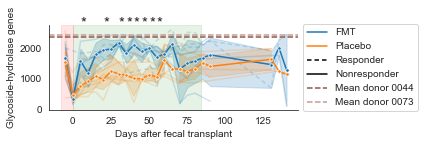

In [94]:
# for each patient, plot the total butyrate cluster counts over time

fig = plt.figure(figsize = (6,2))

#get mean abundance for each donor
cazygh_mean_0044 = cazygh_ct.loc[cazygh_ct['patient'] == '0044']['sb_clust_count'].mean()
cazygh_mean_0073 = cazygh_ct.loc[cazygh_ct['patient'] == '0073']['sb_clust_count'].mean()

ax = sns.lineplot(x='chunk_time', y='sb_clust_count',
                  data=ct_window_mean_df,
                  hue='patient_plt', 
                  palette=dd_pat_treat_name,
                  style='patient_plt',
                  dashes=dd_pat_dash_name,
                  alpha = 0.2)

ax = sns.lineplot(x='chunk_time', y='sb_clust_count',
                  data=ct_window_mean_df,
                  hue='treatment', marker='.', markersize=7)

#label axes
ax.set_ylabel('Glycoside-hydrolase genes')
ax.set_xlabel('Days after fecal transplant')

#label regions of the graph
ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax.axvspan(0, 84, alpha=0.1, color='green') #capsules

#add a line for the mean abundance in the donor samples
ax.axhline(cazygh_mean_0044, color=dd_pat_col['0044'], linestyle='dashed')
ax.axhline(cazygh_mean_0073, color=dd_pat_col['0073'], linestyle='dashed')

#make legends for both plots
legend_elements = [Line2D([0], [0], color=sns.color_palette()[0], label='FMT'),
                   Line2D([0], [0], color=sns.color_palette()[1], label='Placebo'),
                   Line2D([0], [0], color='black', dashes=(3, 2), label='Responder'),
                   Line2D([0], [0], color='black', dashes=(), label='Nonresponder'),
                   Line2D([0], [0], color=dd_pat_col['0044'], linestyle='dashed', 
                          label='Mean donor 0044'),
                   Line2D([0], [0], color=dd_pat_col['0073'], linestyle='dashed', 
                          label='Mean donor 0073')]
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1,0.5))

#add asterisks for signficant differences
for time in ttest_res.loc[ttest_res['p'] < 0.05]['chunk_time'].values:
    ax.annotate('*', xy=(time, 2680), size=15)

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/cazy_gh_genecluster_counts_mean_2019-04-15.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/cazy_gh_genecluster_counts_mean_2019-04-15.pdf',
            dpi=300)

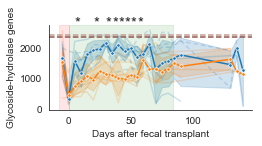

In [13]:
#NO LEGEND

fig = plt.figure(figsize = (3.75,2))

#get mean abundance for each donor
cazygh_mean_0044 = cazygh_ct.loc[cazygh_ct['patient'] == '0044']['sb_clust_count'].mean()
cazygh_mean_0073 = cazygh_ct.loc[cazygh_ct['patient'] == '0073']['sb_clust_count'].mean()

ax = sns.lineplot(x='chunk_time', y='sb_clust_count',
                  data=ct_window_mean_df,
                  hue='patient_plt', 
                  palette=dd_pat_treat_name,
                  style='patient_plt',
                  dashes=dd_pat_dash_name,
                  alpha = 0.2)

ax = sns.lineplot(x='chunk_time', y='sb_clust_count',
                  data=ct_window_mean_df,
                  hue='treatment', marker='.', markersize=7)

#label axes
ax.set_ylabel('Glycoside-hydrolase genes')
ax.set_xlabel('Days after fecal transplant')

#label regions of the graph
ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax.axvspan(0, 84, alpha=0.1, color='green') #capsules

#add a line for the mean abundance in the donor samples
ax.axhline(cazygh_mean_0044, color=dd_pat_col['0044'], linestyle='dashed')
ax.axhline(cazygh_mean_0073, color=dd_pat_col['0073'], linestyle='dashed')

ax.legend_.remove()

#add asterisks for signficant differences
for time in ttest_res.loc[ttest_res['p'] < 0.05]['chunk_time'].values:
    ax.annotate('*', xy=(time, 2680), size=15)

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/cazy_gh_genecluster_counts_mean_nolgd_2019-05-09.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/cazy_gh_genecluster_counts_mean_nolgd_2019-05-09.pdf',
            dpi=300)

## Area under the curve

In [44]:
#for each patient, calculate the area under the curve
aucs_full = []
aucs_treatment = []
aucs_pfmt = []
for patient, sub_df in ct_window_mean_df.groupby('patient'):
    #get full timeline
    auc = np.trapz(sub_df['sb_clust_count'], sub_df['chunk_time'])
    aucs_full.append([patient, auc])
    
    #get only treatment period
    tmp_df = sub_df.loc[sub_df['chunk_time'].between(1, 86)]
    auc = np.trapz(tmp_df['sb_clust_count'], tmp_df['chunk_time'])
    aucs_treatment.append([patient, auc])
    
    #get all of post fmt
    tmp_df = sub_df.loc[sub_df['chunk_time'] > 0]
    auc = np.trapz(tmp_df['sb_clust_count'], tmp_df['chunk_time'])
    aucs_pfmt.append([patient, auc])

In [45]:
aucs_full_df = pd.DataFrame(aucs_full, 
                            columns=['patient', 'auc'])
aucs_treatment_df = pd.DataFrame(aucs_treatment, 
                                 columns=['patient', 'auc'])
aucs_pfmt_df = pd.DataFrame(aucs_pfmt, 
                            columns=['patient', 'auc'])

aucs_full_df = aucs_full_df.merge(md_pat)
aucs_treatment_df = aucs_treatment_df.merge(md_pat)
aucs_pfmt_df = aucs_pfmt_df.merge(md_pat)

In [49]:
#get ttest for full period
tmp = stats.ttest_ind(aucs_full_df.loc[aucs_full_df['treatment'] == 'fmt']['auc'],
                      aucs_full_df.loc[aucs_full_df['treatment'] == 'placebo']['auc'])
print(tmp)

#get ttest for treatment period
tmp = stats.ttest_ind(aucs_treatment_df.loc[aucs_treatment_df['treatment'] == 'fmt']['auc'],
                      aucs_treatment_df.loc[aucs_treatment_df['treatment'] == 'placebo']['auc'])
print(tmp)

#get ttest for treatment and followup
tmp = stats.ttest_ind(aucs_pfmt_df.loc[aucs_pfmt_df['treatment'] == 'fmt']['auc'],
                      aucs_pfmt_df.loc[aucs_pfmt_df['treatment'] == 'placebo']['auc'])
print(tmp)


Ttest_indResult(statistic=2.064797324048268, pvalue=0.06585565122998845)
Ttest_indResult(statistic=2.7445084604937167, pvalue=0.020672167385051603)
Ttest_indResult(statistic=1.9508049063143316, pvalue=0.07964195269975818)


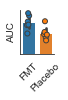

In [92]:
#plot aucs during
fig = plt.figure(figsize = (1,1.5))

ax = sns.barplot(x='treatment', y='auc', data=aucs_treatment_df)
ax = sns.stripplot(x='treatment', y='auc', data=aucs_treatment_df,
                   linewidth=1)
ax.set_ylabel('AUC')
ax.set_xlabel('')

labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'FMT'
labels[1] = 'Placebo'
ax.set_xticklabels(labels)

#remove y ticks
ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,
    labelleft=False)

#remove x ticks
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    rotation=45)

#ax.annotate('*', xy=(0.5, 180000), size=15)

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/cazy_gh_auc_2019-04-15.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/cazy_gh_auc_2019-04-15.pdf',
            dpi=300)

## GH Source Tracking

In [14]:
#colors for sources
dd_source_set = {'shared': (0.878, 0.878, 0.878),
                 'patient': (0.909, 0.470, 0.470),
                 'env': (0.933, 0.674, 0.349),
                 'donor0044': (0.305, 0.749, 0.776),
                 'donor0073': (0.643, 0.450, 0.850),
                 'donor0044_0073': (0.376, 0.470, 0.803),
                 'donor': (0.376, 0.470, 0.803)}

#make a dictionary of patient to publication label
pub_label_dict = md_pat.set_index('patient').to_dict()['label_pub']

In [13]:
#make gene dict
donor_gene_dict = {'0044': set(cazygh_f_md.loc[cazygh_f_md['patient'] == '0044']['Family']),
                   '0073': set(cazygh_f_md.loc[cazygh_f_md['patient'] == '0073']['Family'])}

cazygh_source = []
for patient, sub_df in cazygh_f_md.groupby('patient'):
    if patient in ['0044', '0073']:
        continue
    #get patient baseline vf genes
    bl_sam = md.loc[(md['patient'] == patient) & \
                    (md['days_past_fmt'] < -5)]['sample_id'].tolist()
    bl_genes = set(sub_df.loc[sub_df['sample_id'].isin(bl_sam)]['Family'])
    
    for sample, sub_sub_df in sub_df.groupby('sample_id'):
        sam_genes = set(sub_sub_df['Family'])
        
        if sub_df['treatment'].iloc[0] == 'placebo':
            pat_genes = sam_genes & bl_genes #patient vf
            env_genes = sam_genes - bl_genes #env vf
            
            cazygh_source.extend([[patient, sample, 
                                x, 'patient'] for x in pat_genes])
            cazygh_source.extend([[patient, sample, 
                                x, 'env'] for x in env_genes])
        
        elif sub_df['treatment'].iloc[0] == 'fmt':
            donor = sub_df['fmt_induction'].iloc[0]
            donor_genes = donor_gene_dict[donor]
            
            pat_genes = (sam_genes & bl_genes) - donor_genes #patient amr
            don_genes = (donor_genes & sam_genes) - bl_genes #donor amr
            shr_genes = donor_genes & sam_genes & bl_genes #shared amr
            env_genes = sam_genes - donor_genes - bl_genes #env amr
            
            cazygh_source.extend([[patient, sample, 
                                x, 'patient'] for x in pat_genes])
            cazygh_source.extend([[patient, sample, 
                                x, 'env'] for x in env_genes])
            cazygh_source.extend([[patient, sample, 
                                x, 'donor'] for x in don_genes])
            cazygh_source.extend([[patient, sample, 
                                x, 'shared'] for x in shr_genes])

cazygh_source_df = pd.DataFrame(cazygh_source, 
                              columns=['patient', 'sample_id', 
                                       'Family', 'source'])

In [14]:
# add metadata
cazygh_source_df = cazygh_source_df.merge(cazygh_f_md)

In [15]:
# write to a file
cazygh_source_df.to_csv('/Users/ndchu/Documents/uc_fmt/metagenomics/function/cazy_gh/cazygh_source_2019-05-05.tsv.gz',
                     sep='\t', index=False, compression='gzip')

In [15]:
# read in a file
cazygh_source_df = pd.read_csv('/Users/ndchu/Documents/uc_fmt/metagenomics/function/cazy_gh/cazygh_source_2019-05-05.tsv.gz',
                           sep='\t', compression='gzip', dtype={'patient': 'object',
                                                                'fmt': 'object',
                                                                'fmt_induction': 'object'})

/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [16]:
# get frequencies over time
cazygh_source_freq = cazygh_source_df.groupby(['patient', 'sample_id', 
                                         'days_past_fmt', 'source']).size()
cazygh_sample_sum = cazygh_source_df.groupby(['patient', 'sample_id', 
                                         'days_past_fmt']).size()

cazygh_source_freq = cazygh_source_freq.rename('source_count').reset_index()
cazygh_sample_sum = cazygh_sample_sum.rename('cazygh_count').reset_index()

cazygh_source_freq = cazygh_source_freq.merge(cazygh_sample_sum)
cazygh_source_freq.loc[:, 'source_freq'] = cazygh_source_freq['source_count'] / cazygh_source_freq['cazygh_count']

In [25]:
#get rid of samples with less than 2 butyrate genes, since they are likely errors
cazygh_source_freq = cazygh_source_freq.loc[cazygh_source_freq['cazygh_count'] > 1]

#fill the zeroes
cazygh_source_freq_ftab = cazygh_source_freq.pivot(index='sample_id',
                                               columns='source',
                                               values='source_freq')
cazygh_source_freq_filled = pd.melt(cazygh_source_freq_ftab.reset_index(),
                                  id_vars='sample_id',
                                  var_name='source',
                                  value_name='source_freq')
#add metadata
cazygh_source_freq_filled = cazygh_source_freq_filled.fillna(0)
tmp = cazygh_source_freq[['sample_id', 'source', 'source_count']]
cazygh_source_freq_filled = cazygh_source_freq_filled.merge(tmp, how='outer').fillna(0)
tmp = cazygh_source_freq[['sample_id', 'cazygh_count']].drop_duplicates()
cazygh_source_freq_filled = cazygh_source_freq_filled.merge(tmp)
cazygh_source_freq_filled = cazygh_source_freq_filled.merge(md)

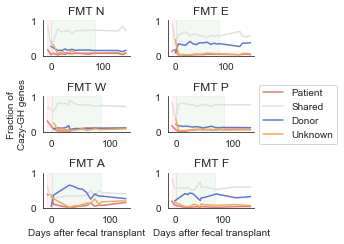

In [19]:
# plot these cazygh sources
#collapse all donor categories

fig = plt.figure(figsize = (5,3.5))

counter = 1
for patient, sub_df in cazygh_source_freq.groupby('patient'):
    if patient in ['001', '007', '008', '010', '011', '014']:
        ax = fig.add_subplot(3,2,counter)
        sns.lineplot(x='days_past_fmt', y='source_freq',
                     hue='source', data=sub_df, palette=dd_source_set)
        
        ax.axvspan(-8, 0, alpha=0.05, color='red') #antibiotics
        ax.axvspan(0, 84, alpha=0.05, color='green') #capsules
        
        ax.set_title(pub_label_dict[patient])
        
        ax.set_ylim(0, 1)
        
        if counter in [3]:
            ax.set_ylabel('Fraction of\nCazy-GH genes')
        else:
            ax.set_ylabel('')
        
        if counter in [5, 6]:
            ax.set_xlabel('Days after fecal transplant')
        else:
            ax.set_xlabel('')
        
        if counter != 4:
            ax.legend_.remove()
        else:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
                     labels=['Patient', 'Shared',
                             'Donor', 'Unknown']
                     )
        
        counter += 1

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/cazygh_engfmt_ts_2019-05-07.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/cazygh_engfmt_ts_2019-05-07.pdf',
            dpi=300)

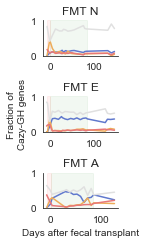

In [26]:
# plot FMT N, E, and A

fig = plt.figure(figsize = (2,3.5))

counter = 1
for patient, sub_df in cazygh_source_freq_filled.groupby('patient'):
    if patient in ['001', '007', '011']:
        ax = fig.add_subplot(3,1,counter)
        sns.lineplot(x='days_past_fmt', y='source_freq',
                     hue='source', data=sub_df, palette=dd_source_set)
        
        ax.axvspan(-8, 0, alpha=0.05, color='red') #antibiotics
        ax.axvspan(0, 84, alpha=0.05, color='green') #capsules
        
        ax.set_title(pub_label_dict[patient])
        
        ax.set_ylim(0, 1)
        
        if counter in [2]:
            ax.set_ylabel('Fraction of\nCazy-GH genes')
        else:
            ax.set_ylabel('')
        
        if counter in [3]:
            ax.set_xlabel('Days after fecal transplant')
        else:
            ax.set_xlabel('')
        
        ax.legend_.remove()
        
        counter += 1

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/cazygh_engfmt_ts_NEA_2019-05-07.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/cazygh_engfmt_ts_NEA_2019-05-07.pdf',
            dpi=300)

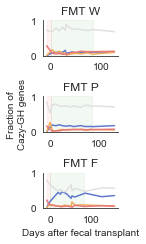

In [27]:
# plot FMT WPF

fig = plt.figure(figsize = (2,3.5))

counter = 1
for patient, sub_df in cazygh_source_freq_filled.groupby('patient'):
    if patient in ['008', '010', '014']:
        ax = fig.add_subplot(3,1,counter)
        sns.lineplot(x='days_past_fmt', y='source_freq',
                     hue='source', data=sub_df, palette=dd_source_set)
        
        ax.axvspan(-8, 0, alpha=0.05, color='red') #antibiotics
        ax.axvspan(0, 84, alpha=0.05, color='green') #capsules
        
        ax.set_title(pub_label_dict[patient])
        
        ax.set_ylim(0, 1)
        
        if counter in [2]:
            ax.set_ylabel('Fraction of\nCazy-GH genes')
        else:
            ax.set_ylabel('')
        
        if counter in [3]:
            ax.set_xlabel('Days after fecal transplant')
        else:
            ax.set_xlabel('')
        
        ax.legend_.remove()
        
        counter += 1

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/cazygh_engfmt_ts_WPF_2019-05-07.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/cazygh_engfmt_ts_WPF_2019-05-07.pdf',
            dpi=300)